In [49]:
%%html
<style type='text/css'>
.CodeMirror{
    font-size: 12px;
}

div.output_area pre {
    font-size: 12px;
}
</style>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)

print(pd.__version__)

1.3.4


# Tìm 10 kệ hàng (aisle) bán được nhiều nhất

# 0. Đọc dữ liệu lớn từ file .csv bằng Pandas với `chunk`

In [32]:
order_filepath = 'data-instacart/order_products__train.csv'
order_products = pd.read_csv(order_filepath, chunksize=500000)

In [33]:
# In ra từng chunk (DataFrame)
for chunk in order_products:
    print(chunk)
    print("\n")

        order_id  product_id  add_to_cart_order  reordered
0              1       49302                  1          1
1              1       11109                  2          1
2              1       10246                  3          0
3              1       49683                  4          0
4              1       43633                  5          1
...          ...         ...                ...        ...
499995   1227734       43086                 13          0
499996   1227734        4503                 14          0
499997   1227734       11733                 15          0
499998   1227734        2480                 16          0
499999   1227747       24852                  1          1

[500000 rows x 4 columns]


        order_id  product_id  add_to_cart_order  reordered
500000   1227747       17429                  2          1
500001   1227747       49215                  3          1
500002   1227747       43961                  4          1
500003   1227747       2433

In [5]:
# Tiếp tục gọi lệnh in lại như trên
for chunk in order_products:
    print(chunk)
    print("\n")

# 1. Thử tìm các aisle tương ứng với 1 chunk nhỏ dữ liệu

**Đọc dữ liệu các sản phẩm đã được bán trong các order**
- File: order_products__train.csv
- Header: order_id,product_id,add_to_cart_order,reordered

In [48]:
N = 500000

order_products = pd.read_csv(order_filepath, chunksize=N, usecols=['product_id'])
chunk0 = next(order_products)
chunk0

,product_id
0,49302
1,11109
2,10246
3,49683
4,43633
...,...
499995,43086
499996,4503
499997,11733
499998,2480


**Đọc danh sách các sản phẩm và aisle tương ứng**

In [7]:
product_info = pd.read_csv('data-instacart/products.csv')
product_info.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
product_aisle = product_info[['product_id', 'aisle_id']]
product_aisle

,product_id,aisle_id
0,1,61
1,2,104
2,3,94
3,4,38
4,5,5
...,...,...
49683,49684,124
49684,49685,42
49685,49686,112
49686,49687,41


In [9]:
# Thử merge
pd.merge(chunk0, product_aisle, on='product_id')

,product_id,aisle_id
0,49302,120
1,49302,120
2,11109,108
3,11109,108
4,11109,108
...,...,...
499995,18657,133
499996,10905,100
499997,29739,20
499998,13969,20


In [10]:
# Gán kết quả vào biến (chỉ lọc ra 'aisle_id')
order_aisle = pd.merge(chunk0, product_aisle, on='product_id')['aisle_id']
order_aisle

0         120
1         120
2         108
3         108
4         108
         ... 
499995    133
499996    100
499997     20
499998     20
499999     19
Name: aisle_id, Length: 500000, dtype: int64

In [11]:
# Thử đếm xem mỗi aisle_id xuất hiện bao nhiêu lần trong chunk này
chunk0_aisle_counts = order_aisle.value_counts().reset_index()
chunk0_aisle_counts

,index,aisle_id
0,83,54999
1,24,54178
2,123,28389
3,120,19904
4,21,15076
...,...,...
129,103,157
130,102,126
131,82,111
132,113,109


In [12]:
# Gán lại tên cột
chunk0_aisle_counts.columns = ['aisle_id', 'counts']
chunk0_aisle_counts

,aisle_id,counts
0,83,54999
1,24,54178
2,123,28389
3,120,19904
4,21,15076
...,...,...
129,103,157
130,102,126
131,82,111
132,113,109


**Viết lại các thao tác trên thành 1 hàm**

In [13]:
# Hàm lọc ra số lần aisle xuất hiện ở mỗi chunk
def Select_Aisle_ID(chunk):
    order_aisle = pd.merge(chunk, product_aisle, on='product_id')['aisle_id']
    aisle_count = order_aisle.value_counts().reset_index()
    aisle_count.columns = ['aisle_id', 'counts']
    
    return aisle_count

In [14]:
# Thử gọi hàm với chunk0 ở trên
Select_Aisle_ID(chunk0)

,aisle_id,counts
0,83,54999
1,24,54178
2,123,28389
3,120,19904
4,21,15076
...,...,...
129,103,157
130,102,126
131,82,111
132,113,109


# 2. Thực hiện với nhiều chunk

In [15]:
import datetime

In [36]:
# Đọc lại dữ liệu:
N = 500000
order_products = pd.read_csv(order_filepath, chunksize=N, usecols=['product_id'])

In [37]:
# Xử lý từng chunk và đưa vào danh sách kết quả
ket_qua = []

start = datetime.datetime.now()
for i, chunk in enumerate(order_products):
    #if i > 12: break
    print("Chunk: ", i)
    chunk_count = Select_Aisle_ID(chunk)
    ket_qua.append(chunk_count)

end = datetime.datetime.now()
print(f"Hoàn tất cho {i+1} chunk. Thời gian:", end-start)

Chunk:  0
Chunk:  1
Chunk:  2
Hoàn tất cho 3 chunk. Thời gian: 0:00:00.353424


In [38]:
print(ket_qua)

[     aisle_id  counts
0          83   54999
1          24   54178
2         123   28389
3         120   19904
4          21   15076
..        ...     ...
129       103     157
130       102     126
131        82     111
132       113     109
133       132      98

[134 rows x 2 columns],      aisle_id  counts
0          24   54309
1          83   54022
2         123   28262
3         120   19770
4          21   14980
..        ...     ...
129        10     162
130       102     125
131        82     116
132       113      98
133       132      95

[134 rows x 2 columns],      aisle_id  counts
0          24   41986
1          83   41588
2         123   21842
3         120   15566
4          21   11643
..        ...     ...
129       134     119
130       132      94
131       113      87
132        82      79
133       102      77

[134 rows x 2 columns]]


**Kết hợp các kết quả thành 1 DataFrame**

In [39]:
total_aisle_count = pd.concat(ket_qua)
print(total_aisle_count.shape)

(402, 2)


In [40]:
total_aisle_count

,aisle_id,counts
0,83,54999
1,24,54178
2,123,28389
3,120,19904
4,21,15076
...,...,...
129,134,119
130,132,94
131,113,87
132,82,79


**Sử dụng groupby để tổng hợp kết quả**

In [41]:
total_aisle_count = total_aisle_count.groupby('aisle_id').sum().reset_index()
total_aisle_count

,aisle_id,counts
0,1,2936
1,2,3873
2,3,17449
3,4,9917
4,5,2905
...,...,...
129,130,6352
130,131,11298
131,132,287
132,133,897


**Lấy ra 10 dòng có giá trị đếm cao nhất**

In [42]:
top10_aisle_id = total_aisle_count.nlargest(10, columns='counts')
top10_aisle_id

,aisle_id,counts
82,83,150609
23,24,150473
122,123,78493
119,120,55240
20,21,41699
114,115,36617
83,84,32644
106,107,31269
90,91,26240
111,112,23635


**Vẽ lên biểu đồ**

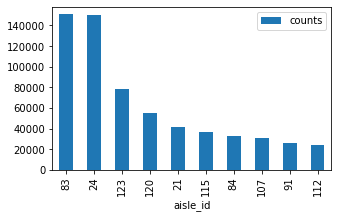

In [43]:
top10_aisle_id.plot.bar(x='aisle_id', y='counts', figsize=(5,3))
plt.show()
plt.close('all')

**Lấy tên của các aisle tương ứng trong file `aisles.csv`**

In [44]:
aisle_info = pd.read_csv('data-instacart/aisles.csv')
aisle_info.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [45]:
top10_aisle = pd.merge(top10_aisle_id, aisle_info, on='aisle_id')
top10_aisle

,aisle_id,counts,aisle
0,83,150609,fresh vegetables
1,24,150473,fresh fruits
2,123,78493,packaged vegetables fruits
3,120,55240,yogurt
4,21,41699,packaged cheese
5,115,36617,water seltzer sparkling water
6,84,32644,milk
7,107,31269,chips pretzels
8,91,26240,soy lactosefree
9,112,23635,bread


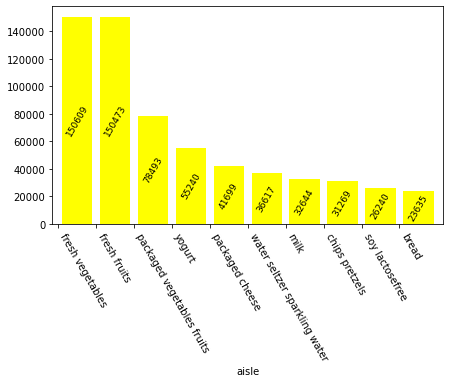

In [46]:
ax = top10_aisle.plot.bar(x='aisle', y='counts', width=0.8, figsize=(7,4), 
                           color='yellow', legend=None, rot=-60)
ax.bar_label(container=ax.containers[0], label_type='center', 
             fontsize=9, rotation=60)

ax.set_xticks(top10_aisle.index-0.5)
ax.set_xticklabels(top10_aisle['aisle'], ha='left')

plt.show()
plt.close('all')

**LUYỆN TẬP: Thực hiện lại việc vẽ biểu đồ ở trên với tên được chuẩn hóa**

In [47]:
# Tên với ký tự đầu in hoa
top10_aisle['aisle'].str.title()

0                 Fresh Vegetables
1                     Fresh Fruits
2       Packaged Vegetables Fruits
3                           Yogurt
4                  Packaged Cheese
5    Water Seltzer Sparkling Water
6                             Milk
7                   Chips Pretzels
8                  Soy Lactosefree
9                            Bread
Name: aisle, dtype: object

In [ ]:
???